# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [2]:
#Load data.
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

In [3]:
#Import needed packages.
import numpy as np
import numpy.random as random
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pylab
import seaborn as sns

sns.set()

df.info() 
df.head()
#variables: temperature, gender, heart_rate

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


## Is the distribution of body temperatures normal?

A normal probability plot, a quantile-quantile plot (QQ plot) of the standardized data against the standard normal distribution, can be used to examine whether the distribution of body temperatures is normal. 

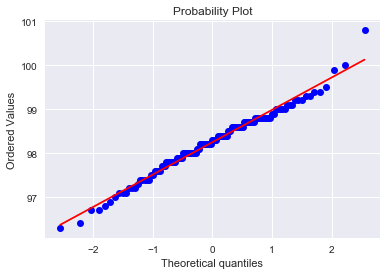

In [4]:
#QQ plot

stats.probplot(df['temperature'], dist="norm", plot=pylab)
pylab.show()

The points in the QQ plot approximate the straight line, suggesting the distribution of body temparatures is normal.

In [5]:
def ecdf(data):
    #returns x and y data for empirical cumulative distribution function
    
    x=np.sort(data)
    y=np.arange(1,len(x)+1)/len(x)
    
    return x,y



In [6]:
pylab.close()

Another way to determine if data is normally distributed is to examine the cumulative distribution of the data compared to
to the theoretical distribution. Below, the theoretical cdf (blue) is overlaid onto the actual data(green). The empirical data
closely follows the shape of the theoretical cdf, suggesting that the human body temperatures sampled are normally
distributed. 

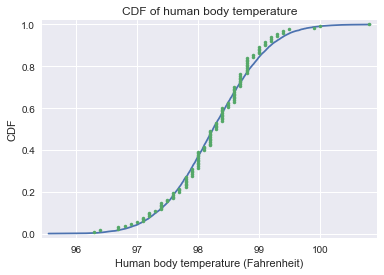

In [7]:
# Compute mean and standard deviation
mean = np.mean(df['temperature'])
std = np.std(df['temperature'])


# Sample out of a normal distribution with computed mean and standard deviation: samples
samples = np.random.normal(mean, std, size=10000)

# Get the CDF of the theoretical (samples) and actual data
x_theor, y_theor = ecdf(samples)
x, y = ecdf(df['temperature'])


# Plot the CDFs 
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.margins(0.02)
_ = plt.xlabel('Human body temperature (Fahrenheit)')
_ = plt.ylabel('CDF')
_ = plt.title('CDF of human body temperature')

plt.show()

##  Is the sample size large? Are the observations independent? 

The sample data (n=130) has greater than 30 observations, thus the sample is large enough for the Central Limit Theorem to apply. The observations are independent, assuming each observation of heart rate, gender, and temperature represents a separate individual.  

## Is the true population mean really 98.6 degrees F? 

**Null hypothesis**: The true population mean human body temperature is equal to 98.6 degrees F. 

**Alternative hypothesis**: The true population mean human body tempetaure is not equal to 98.6 degrees F.



**First, try a bootstrap hypothesis test.**

In [8]:
def bootstrap_replicate_1d(data, func):
    #Generate bootstrap replicate of 1D data.
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample) 

def draw_bs_reps(data, func, size=1):
    #Draw bootstrap replicates

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates



In [9]:
# Make an array of translated temperature data: translated_temp_data
translated_temp_data = df['temperature'] - np.mean(df['temperature']) + 98.6

# Take bootstrap replicates of translated temperature data: bs_replicates
bs_replicates = draw_bs_reps(translated_temp_data, np.mean, 10000)

# Compute fraction of replicates that are less than the observed temperature data: p
p = np.sum(bs_replicates <= np.mean(df['temperature'])) / 10000                      #or len(bs_replicates)

# Print the p-value
print('p = ', p)

p =  0.0


**Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?**

A one-sample test is apporiate in this situation as there is only one set of data to compare to the single value of 98.6 degrees F. 

**In this situation, is it appropriate to use the t or z statistic?**

In this situation, it is appropriate to use the z statistic as the sample size is greater than 30. Moreover, the sample size is large enough that the standard deviation (or variance) can be calculated. 

In [ ]:
#Check if t or z statistic

In [10]:
from statsmodels.stats.weightstats import ztest

ztest(df['temperature'], x2=None, value=98.6)

(-5.4548232923645195, 4.9021570141012155e-08)

**Now try using the other test. How is the result different? Why?** 



In [11]:
#Assuming the other test asked here is the t-test, perform a one-sample T-Test. Use an alpha = 0.05.

stats.ttest_1samp(df['temperature'], 98.6)

#Because hypothesis is two-sided, the output is approriate as is.

#Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)




Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)

The p-value from the z test is 4.9 x 10e-08 while the p-value from the t test is slightly greater (p=2.4 x 10e-07). Since the p-value is less than alpha of 0.05, we can reject the null hypothesis. 

Both p-values (bootstrap hythoseis testing and z-test) are less than alpha. However, the p-value produced from bootstrap testing is 0. 

## Draw a small sample of size 10 from the data and repeat both frequentist tests.
 

  Which one is the correct one to use?
  What do you notice? What does this tell you about the difference in application of the t and z statistic?

In [12]:
#Draw sample (size=10)

sample = np.random.choice(df['temperature'], 10)

**Z test**

In [13]:
from statsmodels.stats.weightstats import ztest

ztest(sample, x2=None, value=98.6)

(-1.2611987084301719, 0.20723726387519492)

**T test**

In [14]:
stats.ttest_1samp(sample, 98.6)

Ttest_1sampResult(statistic=-1.2611987084301719, pvalue=0.23894663892330309)

In this situation, the t test is apporiate as the sample size is less than 10. 
The p-values generated from both these tests are greater than the p-values produced from the tests with original sample of 130.
Since the sample size is smaller, there is less confidence about rejecting the null hypothesis, resulting in the greater p-values.

## At what temperature should we consider someone's temperature to be "abnormal"?
   As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
   
   Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    

**Bootstrap approach with 95% confidence interval**

In [15]:
bs_replicates = draw_bs_reps(df['temperature'], np.mean, 10000)

conf_interval = np.percentile(bs_replicates, [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval for human body temperature:', conf_interval)

95% confidence interval for human body temperature: [ 98.12461538  98.37538462]


**Frequentist Approach**

In [20]:
from scipy.stats import norm
import math

#Find mean.
mean= np.mean(df['temperature'])

#Find population standard deviation.
pop_std = np.std(df['temperature'])

#Find standard error-- divide the population standard deviation by the square root of the sample size.

standard_err = pop_std / math.sqrt(len(df['temperature']))

#Multiply standard error by the approariate z-value (1.96 for 95% confidence interval): margin of error
margin_of_error = 1.96 * standard_err


conf_interval = (mean - margin_of_error,
                 mean + margin_of_error)  

print("95% confidence interval for human body temperature:", conf_interval)

95% confidence interval for human body temperature: (98.12367980442819, 98.37478173403336)


The frequentist and bootstrap approach yield similar confidence intervals.
The **95% confidence interval** lies between 98.12 and 98.37. Temperatures
outside this range may be considered abnormal. 

## Is there a significant difference between males and females in normal temperature? 

What testing approach did you use and why?
Write a story with your conclusion in the context of the original problem. 

First, do some exploratory data analysis:

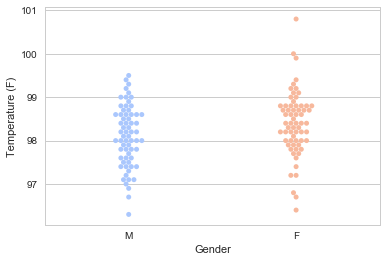

In [17]:
# Create bee swarm plot
sns.set_style('whitegrid')
_ = sns.swarmplot(data=df, x='gender', y='temperature', palette="coolwarm", 
                  order=["M", "F"])

# Label the axes
_ = plt.xlabel('Gender')
_ = plt.ylabel('Temperature (F)')

# Show the plot
plt.show()

From the swarmplot, it appears as though the female body temperatures are more variable than the male body temperatures. We can explore the descriptive statistics of body temperature for both genders using the describe function:

In [18]:
#Get male and female temperatures
m_temp = df[df['gender'] == 'M'].temperature
f_temp =  df[df['gender'] == 'F'].temperature

print(m_temp.describe())
print(f_temp.describe())

count    65.000000
mean     98.104615
std       0.698756
min      96.300000
25%      97.600000
50%      98.100000
75%      98.600000
max      99.500000
Name: temperature, dtype: float64
count     65.000000
mean      98.393846
std        0.743488
min       96.400000
25%       98.000000
50%       98.400000
75%       98.800000
max      100.800000
Name: temperature, dtype: float64


A two-sample T-test can be used to test whether there is a significant difference between female and male mean body temperatures.


**Null Hypothosis**: Mean male body temperature is equal to mean female body temperature.

**Alternate Hypothosis**: Males and females do not have the same mean body temperatures.

**Test Statistic**: difference in means of male and female body temperature


In [19]:
stats.ttest_ind(f_temp, m_temp)

Ttest_indResult(statistic=2.2854345381656103, pvalue=0.023931883122395609)

Since the p-value (0.024) is less than alpha (0.05), we can reject the null hypthoseis. There appears to be a significant difference between mean female body temperature and mean male body temperature. 

## Conclusion

The mean normal body temperature is not 98.6 degrees F as claimed by Carl Wunderlich. Instead, mean human body temperature falls between 98.12 and 98.37 degrees F, with 95% confidence. There is a significant difference between males and females in mean body temperature.